<a href="https://colab.research.google.com/github/shrutikamokashi/Covid19_Projects/blob/master/Project_Covid19_withChatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install xgboost --user

In [0]:
#!pip install folium --user

In [0]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import folium
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")
mms = MinMaxScaler()

In [0]:
cluster_data = pd.read_csv("Countries_usefulFeatures.csv")
data = pd.read_csv("train_w4.csv")
data2 = pd.read_csv("train_w5.csv")
country_geo = "world-countries.json"
fd_i = pd.read_csv("hfi_cc_2019.csv")

testing = pd.read_csv("tested_worldwide.csv")
max_d_test=testing.groupby(["Country_Region"]).agg({"daily_tested":"max"}).reset_index()

In [0]:
r = {
     'Czech Republic': 'Czechia',
     'DR Congo': 'Congo (Brazzaville)',
     'Democratic Republic of the Congo': 'Congo (Kinshasa)',
     'Ivory Coast': "Cote d'Ivoire",
     'Palestine': 'West Bank and Gaza',
     'South Korea': 'Korea, South',
     'Taiwan': 'Taiwan*',
     'United States': 'US',
    }

In [0]:
max_d_test.Country_Region=max_d_test.Country_Region.replace(to_replace=r)
fd_i = fd_i[fd_i.year==2017]
fd_i = fd_i[["ISO_code","pf_score","hf_score"]]
cluster_data.columns

Index(['Country_Region', 'Population_Size', 'Tourism', 'Date_FirstFatality',
       'Date_FirstConfirmedCase', 'Latitude', 'Longtitude', 'Mean_Age',
       'Lockdown_Date', 'Lockdown_Type', 'Country_Code'],
      dtype='object')

In [0]:
data.head()

Id Province_State Country_Region        Date  ConfirmedCases  Fatalities
0   1            NaN    Afghanistan  2020-01-22             0.0         0.0
1   2            NaN    Afghanistan  2020-01-23             0.0         0.0
2   3            NaN    Afghanistan  2020-01-24             0.0         0.0
3   4            NaN    Afghanistan  2020-01-25             0.0         0.0
4   5            NaN    Afghanistan  2020-01-26             0.0         0.0

In [0]:
cluster_data.head()

Country_Region  Population_Size  Tourism Date_FirstFatality  \
0    Afghanistan         37172386    14000         2020-03-23   
1        Albania          2866376  5340000         2020-03-12   
2        Algeria         42228429  2657000         2020-03-13   
3        Andorra            77006  3042000         2020-03-23   
4         Angola         30809762   218000         2020-03-30   

  Date_FirstConfirmedCase   Latitude  Longtitude  Mean_Age Lockdown_Date  \
0              2020-02-25  33.939110   67.709953      17.3    2020-03-24   
1              2020-03-10  41.153332   20.168331      36.2    2020-03-08   
2              2020-02-26  28.033886    1.659626      27.5    2020-03-24   
3              2020-03-03  42.546245    1.601554      37.0    2020-03-16   
4              2020-03-21 -11.202692   17.873887      16.4           NaN   

  Lockdown_Type Country_Code  
0          Full          AFG  
1          Full          ALB  
2          Full          DZA  
3          Full          AND  
4           NaN          AGO

Clustering the data with those 5 columns 'Population_Size', 'Tourism', 'Date_FirstFatality','Date_FirstConfirmedCase', 'Latitude', 'Longtitude', 'Mean_Age'

In [0]:
data_to_cluster = cluster_data.copy()
data_to_cluster = data_to_cluster[["Country_Region","Population_Size","Tourism","Date_FirstFatality","Date_FirstConfirmedCase","Latitude","Longtitude","Mean_Age"]]

In [0]:
data_to_cluster.isnull().sum()

Country_Region              0
Population_Size             0
Tourism                     0
Date_FirstFatality         28
Date_FirstConfirmedCase     0
Latitude                    0
Longtitude                  0
Mean_Age                    0
dtype: int64

In [0]:
data_to_cluster.Date_FirstFatality.fillna("2222-11-11",inplace=True)
data_to_cluster.Date_FirstFatality=pd.to_datetime(data_to_cluster.Date_FirstFatality)
data_to_cluster.Date_FirstFatality = data_to_cluster.Date_FirstFatality.astype(np.int64) // 10**9
data_to_cluster.Date_FirstConfirmedCase=pd.to_datetime(data_to_cluster.Date_FirstConfirmedCase)
data_to_cluster.Date_FirstConfirmedCase = data_to_cluster.Date_FirstConfirmedCase.astype(np.int64) // 10**9
data_to_cluster.drop(["Country_Region"],axis=1,inplace=True)
mms.fit(data_to_cluster)
data_transformed = mms.transform(data_to_cluster)

Checking for the optimal K in Kmeans Clustering

In [0]:
Sum_of_squared_distances = []
K = range(1,90)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

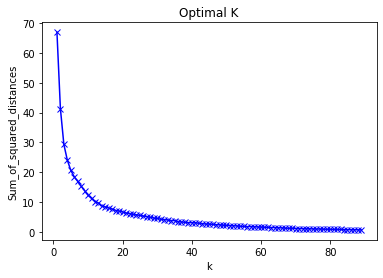

In [0]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Optimal K')
plt.show()

In [0]:
km = KMeans(n_clusters=55,random_state=1995)
km = km.fit(data_transformed)
cluster_data["cluster"] = km.labels_
data.drop("Province_State",axis=1,inplace=True)
data = pd.merge(data,cluster_data,on='Country_Region',how="left")

Creating other useful columns


In [0]:
data.columns

Index(['Id', 'Country_Region', 'Date', 'ConfirmedCases', 'Fatalities',
       'Population_Size', 'Tourism', 'Date_FirstFatality',
       'Date_FirstConfirmedCase', 'Latitude', 'Longtitude', 'Mean_Age',
       'Lockdown_Date', 'Lockdown_Type', 'Country_Code', 'cluster'],
      dtype='object')

In [0]:
temp_data = data.groupby(["Country_Region","Date"]).agg({"ConfirmedCases":"sum","Fatalities":"sum"}).reset_index()
temp_data.columns = ["Country_Region","Date","ConfirmedCases_i","Fatalities_i"]
data.drop_duplicates(["Country_Region","Date"],inplace=True)
data = pd.merge(data,temp_data,on=['Country_Region',"Date"],how="left")
data.drop(["ConfirmedCases","Fatalities"],axis=1,inplace=True)
data.rename(columns={"ConfirmedCases_i":"ConfirmedCases","Fatalities_i":"Fatalities","clusters":"cluster"},inplace=True)

Fatalities percentage



In [0]:
data.Date_FirstFatality.fillna("2222-11-11",inplace=True)
data.isnull().sum()

Id                            0
Country_Region                0
Date                          0
Population_Size               0
Tourism                       0
Date_FirstFatality            0
Date_FirstConfirmedCase       0
Latitude                      0
Longtitude                    0
Mean_Age                      0
Lockdown_Date              3630
Lockdown_Type              3630
Country_Code                  0
cluster                       0
ConfirmedCases                0
Fatalities                    0
dtype: int64

In [0]:
data["Fatalities_rate"]=(data.Fatalities * 100) / data.ConfirmedCases

#Difference between Lockdown Date and First Confirmed Case Date

data["diff_FC_LD"]=(data.Lockdown_Date.astype('datetime64') - data.Date_FirstConfirmedCase.astype('datetime64'))

In [0]:
#Difference between Lockdown Date and First Confirmed Fatality

data["diff_FF_LD"]=(data.Lockdown_Date.astype('datetime64') - data.Date_FirstFatality.astype('datetime64'))

In [0]:
tempd2=data2.loc[(data2.Target=="ConfirmedCases"),["Country_Region","Weight"]]
tempd2["Weight_F"] =  data2.loc[(data2.Target=="Fatalities"),["Weight"]].values
tempd2.columns = ["Country_Region","Weight_C","Weight_F"]
tempd2=tempd2.drop_duplicates(["Country_Region"])
data = pd.merge(data,tempd2[["Country_Region","Weight_C","Weight_F"]],on=['Country_Region'],how="left")
fd_i.columns = ["Country_Code","pf_score","hf_score"]
data = pd.merge(data,max_d_test[["Country_Region","daily_tested"]],on=['Country_Region'],how="left")
data=pd.merge(data,fd_i[["Country_Code","pf_score","hf_score"]],on=['Country_Code'],how="left")
data.daily_tested.fillna(data.loc[data.daily_tested>100,"daily_tested"].min(),inplace=True)
data.hf_score.fillna(data.hf_score.median(),inplace=True)
data.pf_score.fillna(data.pf_score.median(),inplace=True)

Line Plots

Checking the clusters

5 first Clusters

Line plot with Date and ConfirmedCases

In [0]:
for i in data.cluster.unique()[:5]:
    test_df2= data[["Country_Region","Date","ConfirmedCases","cluster"]]
    test_df2=test_df2[ (test_df2.cluster==i) & (test_df2.Date > "2020-03-02") ]
    fig = px.line(test_df2, x="Date", y="ConfirmedCases", color='Country_Region')
    fig.show()

Line plot with Date and Fatalities



In [0]:
for i in data.cluster.unique()[:5]:
    test_df2= data[["Country_Region","Date","Fatalities","cluster"]]
    test_df2=test_df2[ (test_df2.cluster==i) & (test_df2.Date > "2020-03-02") ]
    fig = px.line(test_df2, x="Date", y="Fatalities", color='Country_Region')
    fig.show()

Investigating the clusters


In [0]:
m_cluster=data[data.Country_Region == "Morocco"].cluster.unique()[0]
test_df2=data[ (data.cluster==m_cluster) & (data.Date > "2020-03-05") ]
fig = px.line(test_df2, x="Date", y="Fatalities", color='Country_Region')

for i in test_df2.Country_Region.unique():
    x=test_df2[test_df2.Country_Region == i].Lockdown_Date.unique()[0]
    y=test_df2[(test_df2.Date == x) & (test_df2.Country_Region == i)].Fatalities.values

    if (x is not np.NAN) & (len(y) >0) :
        fig.add_trace(go.Scatter(x=[x], y=[int(y)],
                        mode='markers',
                        name=i+'-lockdown-'+test_df2[test_df2.Country_Region == i].Lockdown_Type.unique()[0],
                        marker_symbol="x",
                        hoverinfo = 'text',
                        text=i+" Country lockdown Date "+ x,
                        marker = dict(
                                 size=15,
                                 color="black"
                             ),

                        ))

fig.show()

In [0]:
m_cluster=data[data.Country_Region == "Spain"].cluster.unique()[0]
test_df2=data[ (data.cluster==m_cluster) & (data.Date > "2020-03-05") ]
fig = px.line(test_df2, x="Date", y="Fatalities", color='Country_Region')

for i in test_df2.Country_Region.unique():
    x=test_df2[test_df2.Country_Region == i].Lockdown_Date.unique()[0]
    y=test_df2[(test_df2.Date == x) & (test_df2.Country_Region == i)].Fatalities.values

    if (x is not np.NAN) & (len(y) >0) :
        fig.add_trace(go.Scatter(x=[x], y=[int(y)],
                        mode='markers',
                        name=i+'-lockdown-'+test_df2[test_df2.Country_Region == i].Lockdown_Type.unique()[0],
                        marker_symbol="x",
                        hoverinfo = 'text',
                        text=i+" Country lockdown Date "+ x,
                        marker = dict(
                                 size=15,
                                 color="black"
                             ),

                        ))

fig.show()

Maps

Fatalities_rate

In [0]:
temp =data[(data.Date == max(data.Date)) ]
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=10, zoom_start=1.5)


for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(temp.iloc[i]['Fatalities_rate'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])
        ,
        radius=int(temp.iloc[i]['Fatalities_rate']*10000)).add_to(m)

m

Mean_Age


In [0]:
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=10, zoom_start=1.5)


for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='green', fill='green',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(temp.iloc[i]['Fatalities_rate'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])
        ,
        radius=int(temp.iloc[i]['Mean_Age']*2500)).add_to(m)

m

Fatalities_rate and Mean_Age


In [0]:
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=8, zoom_start=1.5)

m.choropleth(geo_data=country_geo, data=temp,
             columns=['Country_Code', 'Mean_Age'],
             key_on='feature.id',
             # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'.
             fill_color='RdPu', fill_opacity=0.7, line_opacity=0.1,
             legend_name="Mean_Age")

for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(temp.iloc[i]['Fatalities_rate'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])
        ,
        radius=int(temp.iloc[i]['Fatalities_rate']*10000)).add_to(m)

m

Fatalities_rate and Tourism


In [0]:
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=10, zoom_start=1.5)

m.choropleth(geo_data=country_geo, data=temp,
             columns=['Country_Code', 'Tourism'],
             key_on='feature.id',
             # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'.
             fill_color='RdPu', fill_opacity=0.7, line_opacity=0.1,
             legend_name="Tourism",
             threshold_scale=[14000.0,5000000, 20000000.0, 40000000.0, 60000000.0, 89322000.0]
             )

for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(round(temp.iloc[i]['Fatalities_rate'],2))+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])+
                    '<li><bold>Tourism : '+str(temp.iloc[i]['Tourism'])
        ,
        radius=int(temp.iloc[i]['Fatalities_rate']*10000)).add_to(m)

m

The Human Freedom Index


In [0]:
temp.pf_score = temp.pf_score.astype("float")
temp.hf_score = temp.hf_score.astype("float")
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=8, zoom_start=1.5)

m.choropleth(geo_data=country_geo, data=temp,
             columns=['Country_Code', 'pf_score'],
             key_on='feature.id',
             # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'.
             fill_color='RdPu', fill_opacity=0.7, line_opacity=0.1,
             legend_name="pf_score",
             )

for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(temp.iloc[i]['Fatalities_rate'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])
        ,
        radius=int(temp.iloc[i]['Fatalities_rate']*10000)).add_to(m)

m

In [0]:
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=8, zoom_start=1.5)

m.choropleth(geo_data=country_geo, data=temp,
             columns=['Country_Code', 'hf_score'],
             key_on='feature.id',
             # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'.
             fill_color='RdPu', fill_opacity=0.7, line_opacity=0.1,
             legend_name="hf_score")

for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(temp.iloc[i]['Fatalities_rate'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])
        ,
        radius=int(temp.iloc[i]['Fatalities_rate']*10000)).add_to(m)

m

Number of tests per day by country


In [0]:
temp.daily_tested = temp.daily_tested.astype("float")
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=8, zoom_start=1.5)

m.choropleth(geo_data=country_geo, data=temp,
             columns=['Country_Code', 'daily_tested'],
             key_on='feature.id',
             # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'.
             fill_color='RdPu', fill_opacity=0.7, line_opacity=0.1,
             legend_name="daily_tested",
             threshold_scale=[0.0, 1000, 5000.0, 10000.0,50000.0,100000.0, 318720.0]
            )

for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(temp.iloc[i]['Fatalities_rate'])+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])
        ,
        radius=int(temp.iloc[i]['ConfirmedCases']*1.1)).add_to(m)

m

In [0]:
temp.to_csv("temp.csv",index=False)
temp

Id      Country_Region        Date  Population_Size   Tourism  \
109      110         Afghanistan  2020-05-10         37172386     14000   
219      224             Albania  2020-05-10          2866376   5340000   
329      338             Algeria  2020-05-10         42228429   2657000   
439      452             Andorra  2020-05-10            77006   3042000   
549      566              Angola  2020-05-10         30809762    218000   
...      ...                 ...         ...              ...       ...   
19909  35222             Vietnam  2020-05-10         95540395  15498000   
20019  35336  West Bank and Gaza  2020-05-10          4569087    606000   
20129  35450      Western Sahara  2020-05-10           500000     14000   
20239  35564              Zambia  2020-05-10         17351822   1072000   
20349  35678            Zimbabwe  2020-05-10         14439018   2580000   

      Date_FirstFatality Date_FirstConfirmedCase   Latitude  Longtitude  \
109           2020-03-23              2020-02-25  33.939110   67.709953   
219           2020-03-12              2020-03-10  41.153332   20.168331   
329           2020-03-13              2020-02-26  28.033886    1.659626   
439           2020-03-23              2020-03-03  42.546245    1.601554   
549           2020-03-30              2020-03-21 -11.202692   17.873887   
...                  ...                     ...        ...         ...   
19909         2222-11-11              2020-01-24  14.058324  108.277199   
20019         2020-03-27              2020-03-06  31.946600   35.302700   
20129         2222-11-11              2020-04-06  24.215527  -12.885834   
20239         2020-04-03              2020-03-19 -13.133897   27.849332   
20349         2020-03-24              2020-03-21 -19.015438   29.154857   

       Mean_Age  ... ConfirmedCases Fatalities Fatalities_rate  diff_FC_LD  \
109        17.3  ...         4402.0      120.0        2.726034          28   
219        36.2  ...          868.0       31.0        3.571429          -2   
329        27.5  ...         5723.0      502.0        8.771623          27   
439        37.0  ...          755.0       48.0        6.357616          13   
549        16.4  ...           45.0        2.0        4.444444          62   
...         ...  ...            ...        ...             ...         ...   
19909      37.0  ...          288.0        0.0        0.000000          55   
20019      37.0  ...          375.0        2.0        0.533333          34   
20129      26.8  ...            6.0        0.0        0.000000          -1   
20239      17.1  ...          267.0        7.0        2.621723          62   
20349      19.0  ...           36.0        4.0       11.111111           9   

       diff_FF_LD  Weight_C  Weight_F  daily_tested  pf_score  hf_score  
109             1  0.058359  0.583587         104.0      6.97     6.835  
219            -4  0.067225  0.672251         269.0      8.01     7.840  
329            11  0.057096  0.570961         104.0      5.20     4.990  
439            -7  0.088773  0.887732         104.0      6.97     6.835  
549            42  0.058587  0.585874         104.0      5.98     5.400  
...           ...       ...       ...           ...       ...       ...  
19909          -7  0.054511  0.545111       70315.0      6.31     6.290  
20019          13  0.065211  0.652111         831.0      6.97     6.835  
20129          -7  0.076083  0.760829         104.0      6.97     6.835  
20239          42  0.060299  0.602992         104.0      6.13     6.490  
20349           6  0.060711  0.607106         104.0      5.61     5.650  

[185 rows x 24 columns]

Fatalities_rate and the difference between lockDown Date and FirstConfirmedCase


In [0]:
temp.diff_FC_LD.replace({np.NAN:"62"},inplace=True)
temp.diff_FF_LD.replace({np.NAN:"42"},inplace=True)
temp.diff_FC_LD=temp.diff_FC_LD.astype(str)
temp.diff_FF_LD=temp.diff_FF_LD.astype(str)
temp.diff_FC_LD=temp.diff_FC_LD.str[:2]
temp.diff_FF_LD=temp.diff_FF_LD.str[:2]
temp.diff_FC_LD = temp.diff_FC_LD.astype(int)
temp.diff_FF_LD = temp.diff_FF_LD.astype(int)

In [0]:
m = folium.Map(location=[0, 0], tiles='cartodbpositron',
               min_zoom=1, max_zoom=10, zoom_start=1.5)

m.choropleth(geo_data=country_geo, data=temp,
             columns=['Country_Code', 'diff_FC_LD'],
             key_on='feature.id',
             # 'BuGn', 'BuPu', 'GnBu', 'OrRd', 'PuBu', 'PuBuGn', 'PuRd', 'RdPu','YlGn', 'YlGnBu', 'YlOrBr', and 'YlOrRd'.
             fill_color='RdPu', fill_opacity=0.7, line_opacity=0.1,
             legend_name="FirstCaseConfirmed_diff_lockdown"
             )

for i in range(0, len(temp)):
    folium.Circle(
        location=[temp.iloc[i]['Latitude'], temp.iloc[i]['Longtitude']],
        color='crimson', fill='crimson',
        tooltip =   '<li><bold>Country : '+str(temp.iloc[i]['Country_Region'])+
                    '<li><bold>Confirmed : '+str(temp.iloc[i]['ConfirmedCases'])+
                    '<li><bold>Death_rate : '+str(round(temp.iloc[i]['Fatalities_rate'],2))+
                    '<li><bold>Deaths : '+str(temp.iloc[i]['Fatalities'])+
                    '<li><bold>lockdown date : '+str(temp.iloc[i]['Lockdown_Date'])+
                    '<li><bold>first case date : '+str(temp.iloc[i]['Date_FirstConfirmedCase'])+
                    '<li><bold>mean age : '+str(temp.iloc[i]['Mean_Age'])+
                    '<li><bold>Tourism : '+str(temp.iloc[i]['Tourism'])
        ,
        radius=int(temp.iloc[i]['Fatalities_rate']*10000)).add_to(m)

m

Feature Importance 
Correlation

In [0]:
data.pf_score = data.pf_score.astype("float")
data.hf_score = data.hf_score.astype("float")

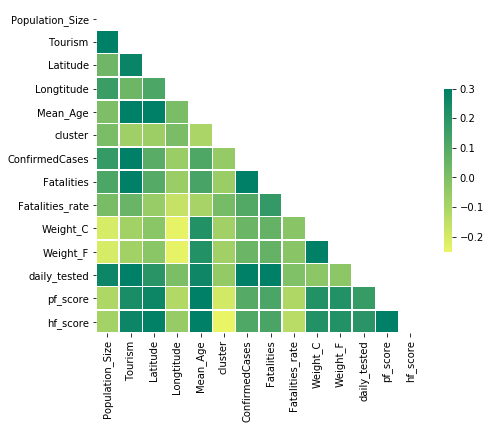

In [0]:
import seaborn as sns
corr = data.drop(["Id"],axis=1).corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,mask=mask,cmap='summer_r',vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.5})

Feature importance with random forest


In [0]:
def feature_imp(df,model):
    fi = pd.DataFrame()
    fi["feature"] = df.columns
    fi["importance"] = model.feature_importances_
    return fi.sort_values(by="importance", ascending=False)

In [0]:
train = data.copy()

In [0]:
train.Date_FirstFatality.fillna("2222-11-11",inplace=True)
train.Date_FirstFatality=pd.to_datetime(train.Date_FirstFatality)
train.Date_FirstFatality = train.Date_FirstFatality.astype(np.int64) // 10**9

train.Date_FirstConfirmedCase=pd.to_datetime(train.Date_FirstConfirmedCase)
train.Date_FirstConfirmedCase = train.Date_FirstConfirmedCase.astype(np.int64) // 10**9

train.Date=pd.to_datetime(train.Date)
train.Date = train.Date.astype(np.int64) // 10**9

train.Lockdown_Date.fillna("2111-12-12",inplace=True)
train.Lockdown_Date=pd.to_datetime(train.Lockdown_Date)
train.Lockdown_Date = train.Lockdown_Date.astype(np.int64) // 10**9


train.Lockdown_Type = train.Lockdown_Type.astype("category")
train.Lockdown_Type = train.Lockdown_Type.cat.codes

train.diff_FC_LD.replace({np.NAN:"62"},inplace=True)
train.diff_FF_LD.replace({np.NAN:"42"},inplace=True)
train.diff_FC_LD=train.diff_FC_LD.astype(str)
train.diff_FF_LD=train.diff_FF_LD.astype(str)
train.diff_FC_LD=train.diff_FC_LD.str[:2]
train.diff_FF_LD=train.diff_FF_LD.str[:2]
train.diff_FC_LD = train.diff_FC_LD.astype(int)
train.diff_FF_LD = train.diff_FF_LD.astype(int)

In [0]:
train = train[train.Date == max(train.Date)]

In [0]:
rf = RandomForestRegressor(n_estimators = 1000,
                           n_jobs = -1,
                           random_state = 141)
rf.fit(train.drop(['Country_Region',"Id","Fatalities","ConfirmedCases","Fatalities_rate","Date","Country_Code","Date_FirstFatality","Date_FirstConfirmedCase","Lockdown_Date"],axis=1), train["Fatalities"])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=141, verbose=0, warm_start=False)

In [0]:
fimp = feature_imp(train.drop(['Country_Region',"Id","Fatalities","ConfirmedCases","Fatalities_rate","Date","Country_Code","Date_FirstFatality","Date_FirstConfirmedCase","Lockdown_Date"],axis=1),rf)

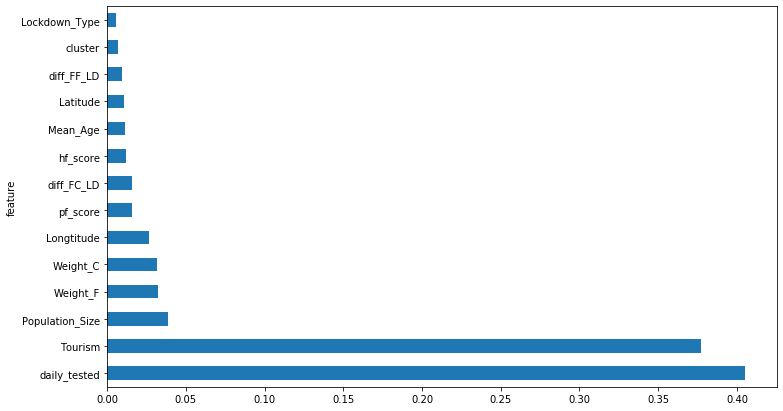

In [0]:
feature_imp(train.drop(['Country_Region',"Id","Fatalities","ConfirmedCases","Fatalities_rate","Date","Country_Code","Date_FirstFatality","Date_FirstConfirmedCase","Lockdown_Date"],axis=1),rf).plot('feature', 'importance', 'barh', figsize=(12,7), legend=False)

Checking the correlation between the Fatalities, Tourism and population size


In [0]:
fig = px.scatter(data[(data.Tourism>100000) & (data.Date == max(data.Date)) ],
                 x='Tourism', y='Fatalities', color='Country_Region', size='Mean_Age', height=700,
                 text='Country_Region',log_x=True,log_y=True)
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

Fatalities_rate and Tourism


In [0]:
fig = px.scatter(data[(data.Population_Size>100000) & (data.Date == max(data.Date)) ],
                 x='Population_Size', y='Fatalities', color='Country_Region', size='Mean_Age', height=700,
                 text='Country_Region',log_x=True,log_y=True)
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [0]:
fig = px.scatter(data[(data.Population_Size>100000) & (data.Date == max(data.Date)) ],
                 x='Weight_F', y='Fatalities', color='Country_Region', size='Mean_Age', height=700,
                 text='Country_Region',log_x=True,log_y=True)
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [0]:
fig = px.scatter(data[(data.daily_tested>200) & (data.Date == max(data.Date)) ],
                 x='daily_tested', y='Fatalities', color='Country_Region', size='Mean_Age', height=700,
                 text='Country_Region',log_x=True,log_y=True)
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

Predicting the ConfirmCases From Fatalities

In [0]:
data.sort_values(["Country_Region"],inplace=True)

In [0]:
def predict_ConfirmedCases(test_country):
    tmp_data=data[(data.Date == max(data.Date))]
    test_data=tmp_data[tmp_data.Country_Region == test_country]
    train_data = tmp_data[(tmp_data.Country_Region !=test_country) & (tmp_data.Fatalities_rate >= 2) & (tmp_data.Fatalities_rate <= 6)]
    #print(test_data)
    
    mms.fit(train_data[['Fatalities',"Population_Size","Tourism"]])
    data_transformed = mms.transform(train_data[['Fatalities',"Population_Size","Tourism"]])
    
    rg = Ridge(alpha=0.00001)
    rg.fit(data_transformed,train_data["ConfirmedCases"])
   
    predictions=rg.predict(mms.transform(test_data[['Fatalities',"Population_Size","Tourism"]]))
    return pd.DataFrame([test_country,predictions[0]]).transpose()

In [0]:
tmp_df = pd.DataFrame([data.Country_Region.unique()]).T
tmp_df.columns =["Country_Region"]
for i in data.Country_Region.unique():
    d=predict_ConfirmedCases(i)
    tmp_df.loc[tmp_df.Country_Region == i,"predicted_C"] = predict_ConfirmedCases(i)[1].values[0]
tmp_df=pd.merge(tmp_df, data.loc[(data.Date == max(data.Date)),["ConfirmedCases","Country_Region"]],how="left",on="Country_Region")

In [0]:
tmp_df.predicted_C = tmp_df.predicted_C.apply(lambda x: int(round(x,2)))
tmp_df[tmp_df.Country_Region.isin(["Morocco","Egypt","Algeria","Tunisia","France","Spain","Italy","Korea, South"])]

Country_Region  predicted_C  ConfirmedCases
2          Algeria        10591          5723.0
53           Egypt        15605          9400.0
62          France       476768        177094.0
85           Italy       529740        219070.0
91    Korea, South        13437         10909.0
117        Morocco        10739          6063.0
157          Spain       477144        224350.0
170        Tunisia         6288          1032.0

In [0]:
tmp_df1 = tmp_df.sort_values(by=['ConfirmedCases'])

In [0]:
from sys import argv
script, pos_file, output = argv
positions = []
for x in tmp_df1['Country_Region'].tail():
    x.rstrip("\n");
    positions.append(x)
listToStr = ','.join([str(elem) for elem in positions]) 
positions[-1]
listToStr

'Russia,Italy,United Kingdom,Spain,US'

In [0]:
temp1 = temp.sort_values(by=['daily_tested'])
temp1


Id       Country_Region        Date  Population_Size   Tourism  \
2969    3872         Burkina Faso  2020-05-10         19751535    144000   
18259  26330             Tanzania  2020-05-10         56318348   1378000   
11659  19034               Malawi  2020-05-10         18143315    871000   
18699  26786  Trinidad and Tobago  2020-05-10          1389858    375000   
109      110          Afghanistan  2020-05-10         37172386     14000   
...      ...                  ...         ...              ...       ...   
7369   14588              Germany  2020-05-10         82905782  38881000   
8799   16070                India  2020-05-10       1352617328  17423000   
17379  25418                Spain  2020-05-10         46796540  82773000   
15399  23366               Russia  2020-05-10        144478050  24551000   
19029  27128                   US  2020-05-10        326687501  79745920   

      Date_FirstFatality Date_FirstConfirmedCase   Latitude  Longtitude  \
2969          2020-03-19              2020-03-11  12.238333   -1.561593   
18259         2020-04-01              2020-03-17  -6.369028   34.888822   
11659         2020-04-08              2020-04-03 -13.254308   34.301525   
18699         2020-03-26              2020-03-15  10.691803  -61.222503   
109           2020-03-23              2020-02-25  33.939110   67.709953   
...                  ...                     ...        ...         ...   
7369          2020-03-10              2020-01-28  51.165691   10.451526   
8799          2020-03-12              2020-01-31  20.593684   78.962880   
17379         2020-03-04              2020-02-02  40.463667   -3.749220   
15399         2020-03-20              2020-02-01  61.524010  105.318756   
19029         2020-03-10              2020-03-10  37.090240  -95.712891   

       Mean_Age  ... ConfirmedCases Fatalities Fatalities_rate  diff_FC_LD  \
2969       17.0  ...          751.0       49.0        6.524634          10   
18259      37.0  ...          509.0       21.0        4.125737          62   
11659      17.4  ...           56.0        3.0        5.357143          62   
18699      33.9  ...          116.0        8.0        6.896552          -2   
109        17.3  ...         4402.0      120.0        2.726034          28   
...         ...  ...            ...        ...             ...         ...   
7369       45.9  ...       171879.0     7569.0        4.403679          52   
8799       26.7  ...        67161.0     2212.0        3.293578          53   
17379      43.2  ...       224350.0    26621.0       11.865835          41   
15399      38.7  ...       209688.0     1915.0        0.913262          55   
19029      37.6  ...      1329092.0    79521.0        5.983107          13   

       diff_FF_LD  Weight_C  Weight_F  daily_tested  pf_score  hf_score  
2969            2  0.059660  0.596596           0.0      7.39     6.730  
18259          42  0.056099  0.560989           0.0      5.75     6.260  
11659          42  0.060100  0.601003          47.0      7.13     6.600  
18699          -1  0.070845  0.708448          66.0      6.54     6.620  
109             1  0.058359  0.583587         104.0      6.97     6.835  
...           ...       ...       ...           ...       ...       ...  
7369           10  0.054886  0.548865       79063.0      9.25     8.530  
8799           12  0.047660  0.476600       85824.0      6.37     6.640  
17379          10  0.056646  0.566455      195631.0      8.69     8.120  
15399           7  0.053182  0.531824      234496.0      5.90     6.340  
19029          13  0.091485  0.914848      318720.0      8.72     8.460  

[185 rows x 24 columns]

In [0]:
#script, pos_file, output = argv
most_test = []
for x in temp1['Country_Region'].tail():
    x.rstrip("\n");
    most_test.append(x)
listToStrC = ','.join([str(elem) for elem in most_test]) 
most_test[-1]
listToStrC

'Germany,India,Spain,Russia,US'

In [0]:
fatalities = []
for x in temp.sort_values('Fatalities')['Country_Region'].tail():
    x.rstrip("\n");
    fatalities.append(x)
listToStrD = ','.join([str(elem) for elem in fatalities]) 
listToStrD

'France,Spain,Italy,United Kingdom,US'

In [0]:
!pip install nltk
import nltk

In [0]:
!python --version

Python 3.7.7


In [0]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mokas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mokas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle
import numpy as np
import random

In [0]:
#!pip install keras
#!pip3 install keras==2.3.0
#!pip install --user tensorflow==1.14.0
#from tensorflow import *
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD


Using TensorFlow backend.


In [0]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']
data_file = open('WHO1.json').read()
#type(data_file)
data_file = data_file.replace('top_affected_countries', listToStr)
data_file = data_file.replace('highest_cases_country', positions[-1])
data_file = data_file.replace('top_testing_countries', listToStrC)
data_file = data_file.replace('highest_testing_countries', most_test[-1])
data_file = data_file.replace('top_death_countries ', listToStrD)
data_file = data_file.replace('highest_death_country', fatalities[-1])

In [0]:
intents = json.loads(data_file)
intents

{'intents': [{'tag': 'greeting',
   'patterns': ['hi there',
    'how are you',
    'is anyone there?',
    'hey',
    'hola',
    'hello',
    'good day'],
   'responses': ['hello, thanks for asking',
    'good to see you again',
    'hi there, how can i help?'],
   'context': ['']},
  {'tag': 'goodbye',
   'patterns': ['bye',
    'see you later',
    'goodbye',
    'nice chatting to you, bye',
    'till next time'],
   'responses': ['see you!', 'have a nice day', 'bye! come back again soon.'],
   'context': ['']},
  {'tag': 'thanks',
   'patterns': ['thanks',
    'thank you',
    "that's helpful",
    'awesome, thanks',
    'thanks for helping me'],
   'responses': ['happy to help!', 'any time!', 'my pleasure'],
   'context': ['']},
  {'tag': 'noanswer',
   'patterns': [],
   'responses': ["sorry, can't understand you",
    'please give me more info',
    'not sure i understand'],
   'context': ['']},
  {'tag': 'any_other_querie',
   'patterns': ['ok', 'okay', 'cool', 'fine', 'oh', '

In [0]:
for intent in intents['intents']:
    for pattern in intent['patterns']:

        # take each word and tokenize it
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        # adding documents
        documents.append((w, intent['tag']))

        # adding classes to our class list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [0]:
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))

classes = sorted(list(set(classes)))

print (len(documents), "documents")

print (len(classes), "classes", classes)

print (len(words), "unique lemmatized words", words)


pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

296 documents
50 classes ['Germany,India,Spain,Russia,US', 'adverse_drug', 'animals_corona', 'ans_admitted', 'antibiotics_for_corona', 'any_other_querie', 'ask_and_get_info', 'blood_pressure', 'blood_pressure_search', 'cause_corona', 'corona_and_other_flu', 'corona_infected_ans', 'corona_infected_que', 'corona_synonym', 'defination_corona', 'emergency_symptoms', 'faq_symptoms_question', 'first_symptom_quetion', 'goodbye', 'greeting', 'handle_answer', 'hospital_search', 'incubation_corona', 'location_identifier', 'mask_and_corona', 'matching_symptoms', 'options', 'patient_age', 'patient_background', 'person_admitted_q', 'pharmacy_search', 'prevention_corona', 'query', 'query_newborn', 'query_pregnancy', 'query_public', 'query_smoking', 'reason_behind_corona', 'risk_catching_corona', 'sars_and_corona', 'send_the_correct_response', 'spread_corona', 'starting_place_corona', 'starting_time_corona', 'survival_corona', 'thanks', 'top_cases', 'top_deaths_countries', 'vaccine_for_corona', 'worr

In [0]:
# initializing training data
training = []
output_empty = [0] * len(classes)
for doc in documents:
    # initializing bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)

    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1

    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")

Training data created


In [0]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(128, input_shape=(len(train_x[0]),), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_y[0]), activation='softmax'))

# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

#fitting and saving the model
hist = model.fit(np.array(train_x), np.array(train_y), epochs=200, batch_size=5, verbose=1)
model.save('chatbot_model.h5', hist)

print("model created")

Epoch 1/200
296/296 [==============================] - 0s 835us/step - loss: 3.8591 - accuracy: 0.0574
Epoch 2/200
296/296 [==============================] - 0s 356us/step - loss: 3.6414 - accuracy: 0.1115
Epoch 3/200
296/296 [==============================] - 0s 270us/step - loss: 3.4532 - accuracy: 0.1419
Epoch 4/200
296/296 [==============================] - 0s 263us/step - loss: 3.2416 - accuracy: 0.1959
Epoch 5/200
296/296 [==============================] - 0s 290us/step - loss: 3.0558 - accuracy: 0.2534
Epoch 6/200
296/296 [==============================] - 0s 280us/step - loss: 2.9339 - accuracy: 0.2736
Epoch 7/200
296/296 [==============================] - 0s 374us/step - loss: 2.7558 - accuracy: 0.2804
Epoch 8/200
296/296 [==============================] - 0s 293us/step - loss: 2.5384 - accuracy: 0.3649
Epoch 9/200
296/296 [==============================] - 0s 273us/step - loss: 2.3462 - accuracy: 0.3818
Epoch 10/200
296/296 [==============================] - 0s 249us/step - l

296/296 [==============================] - ETA: 0s - loss: 0.4630 - accuracy: 0.85 - 0s 296us/step - loss: 0.5040 - accuracy: 0.8378
Epoch 80/200
296/296 [==============================] - 0s 303us/step - loss: 0.4659 - accuracy: 0.8480
Epoch 81/200
296/296 [==============================] - 0s 305us/step - loss: 0.4664 - accuracy: 0.8176
Epoch 82/200
296/296 [==============================] - 0s 317us/step - loss: 0.5243 - accuracy: 0.8142
Epoch 83/200
296/296 [==============================] - 0s 377us/step - loss: 0.4747 - accuracy: 0.8378
Epoch 84/200
296/296 [==============================] - 0s 290us/step - loss: 0.4055 - accuracy: 0.8649
Epoch 85/200
296/296 [==============================] - 0s 290us/step - loss: 0.4911 - accuracy: 0.8277
Epoch 86/200
296/296 [==============================] - 0s 489us/step - loss: 0.4703 - accuracy: 0.8480
Epoch 87/200
296/296 [==============================] - 0s 391us/step - loss: 0.4953 - accuracy: 0.8209
Epoch 88/200
296/296 [=============

Epoch 157/200
296/296 [==============================] - 0s 627us/step - loss: 0.4381 - accuracy: 0.8311
Epoch 158/200
296/296 [==============================] - 0s 428us/step - loss: 0.4634 - accuracy: 0.8243
Epoch 159/200
296/296 [==============================] - 0s 400us/step - loss: 0.4417 - accuracy: 0.8412
Epoch 160/200
296/296 [==============================] - 0s 354us/step - loss: 0.4570 - accuracy: 0.8412
Epoch 161/200
296/296 [==============================] - 0s 370us/step - loss: 0.3692 - accuracy: 0.8615
Epoch 162/200
296/296 [==============================] - 0s 408us/step - loss: 0.4430 - accuracy: 0.8345
Epoch 163/200
296/296 [==============================] - 0s 339us/step - loss: 0.3829 - accuracy: 0.8547
Epoch 164/200
296/296 [==============================] - 0s 398us/step - loss: 0.4310 - accuracy: 0.8412
Epoch 165/200
296/296 [==============================] - ETA: 0s - loss: 0.4038 - accuracy: 0.84 - 0s 532us/step - loss: 0.4010 - accuracy: 0.8514
Epoch 166/200

In [0]:
from keras.models import load_model
model = load_model('chatbot_model.h5')
import json
import random
intents = json.loads(open('WHO1.json').read())
words = pickle.load(open('words.pkl','rb'))
classes = pickle.load(open('classes.pkl','rb'))


In [0]:
def clean_up_sentence(sentence):
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]
    return sentence_words

# return bag of words array: 0 or 1 for each word in the bag that exists in the sentence

def bow(sentence, words, show_details=True):
    # tokenize the pattern
    sentence_words = clean_up_sentence(sentence)
    # bag of words - matrix of N words, vocabulary matrix
    bag = [0]*len(words)
    for s in sentence_words:
        for i,w in enumerate(words):
            if w == s:
                # assign 1 if current word is in the vocabulary position
                bag[i] = 1
                if show_details:
                    print ("found in bag: %s" % w)
    return(np.array(bag))

def predict_class(sentence, model):
    # filter out predictions below a threshold
    p = bow(sentence, words,show_details=False)
    res = model.predict(np.array([p]))[0]
    ERROR_THRESHOLD = 0.25
    results = [[i,r] for i,r in enumerate(res) if r>ERROR_THRESHOLD]
    # sort by strength of probability
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = []
    for r in results:
        return_list.append({"intent": classes[r[0]], "probability": str(r[1])})
    return return_list

def getResponse(ints, intents_json):
    tag = ints[0]['intent']
    list_of_intents = intents_json['intents']
    for i in list_of_intents:
        if(i['tag']== tag):
            result = random.choice(i['responses'])
            break
    return result

def chatbot_response(msg):
    ints = predict_class(msg, model)
    res = getResponse(ints, intents)
    return res


In [0]:
#Creating GUI with tkinter
import tkinter
from tkinter import *


def send():
    msg = EntryBox.get("1.0",'end-1c').strip()
    EntryBox.delete("0.0",END)

    if msg != '':
        ChatLog.config(state=NORMAL)
        ChatLog.insert(END, "You: " + msg + '\n\n')
        ChatLog.config(foreground="#442265", font=("Verdana", 12 ))

        res = chatbot_response(msg)
        ChatLog.insert(END, "Bot: " + res + '\n\n')

        ChatLog.config(state=DISABLED)
        ChatLog.yview(END)


base = Tk()
base.title("Covid-19 Assistant")
base.geometry("400x500")
base.resizable(width=FALSE, height=FALSE)

#Create Chat window
ChatLog = Text(base, bd=0, bg="white", height="8", width="50", font="Arial",)

ChatLog.config(state=DISABLED)

#Bind scrollbar to Chat window
scrollbar = Scrollbar(base, command=ChatLog.yview, cursor="heart")
ChatLog['yscrollcommand'] = scrollbar.set

#Create Button to send message
SendButton = Button(base, font=("Verdana",12,'bold'), text="Send", width="12", height=5,
                    bd=0, bg="#32de97", activebackground="#3c9d9b",fg='#ffffff',
                    command= send )

#Create the box to enter message
EntryBox = Text(base, bd=0, bg="white",width="29", height="5", font="Arial")
#EntryBox.bind("<Return>", send)


#Place all components on the screen
scrollbar.place(x=376,y=6, height=386)
ChatLog.place(x=6,y=6, height=386, width=370)
EntryBox.place(x=128, y=401, height=90, width=265)
SendButton.place(x=6, y=401, height=90)

base.mainloop()